<a href="https://colab.research.google.com/github/mostofk/Economic-Dispatch-using-Unit-Commitment-of-Microgrid-at-Tok-Alaska/blob/main/TOK_Microgrid_UC_code_py.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

    Hour  Grid Import (kW)  Grid Export (kW)  BESS Charge (kW)  \
0      0             0.000             59.29               0.0   
1      1             0.000              0.00               0.0   
2      2             0.000              0.00               0.0   
3      3             0.000              0.00               0.0   
4      4            67.570              0.00               0.0   
5      5            73.320              0.00               0.0   
6      6            77.260              0.00               0.0   
7      7            80.940              0.00               0.0   
8      8            80.190              0.00               0.0   
9      9           157.150              0.00               0.0   
10    10           251.330              0.00               0.0   
11    11           270.448              0.00               0.0   
12    12           257.106              0.00               0.0   
13    13           240.601              0.00               0.0   
14    14  

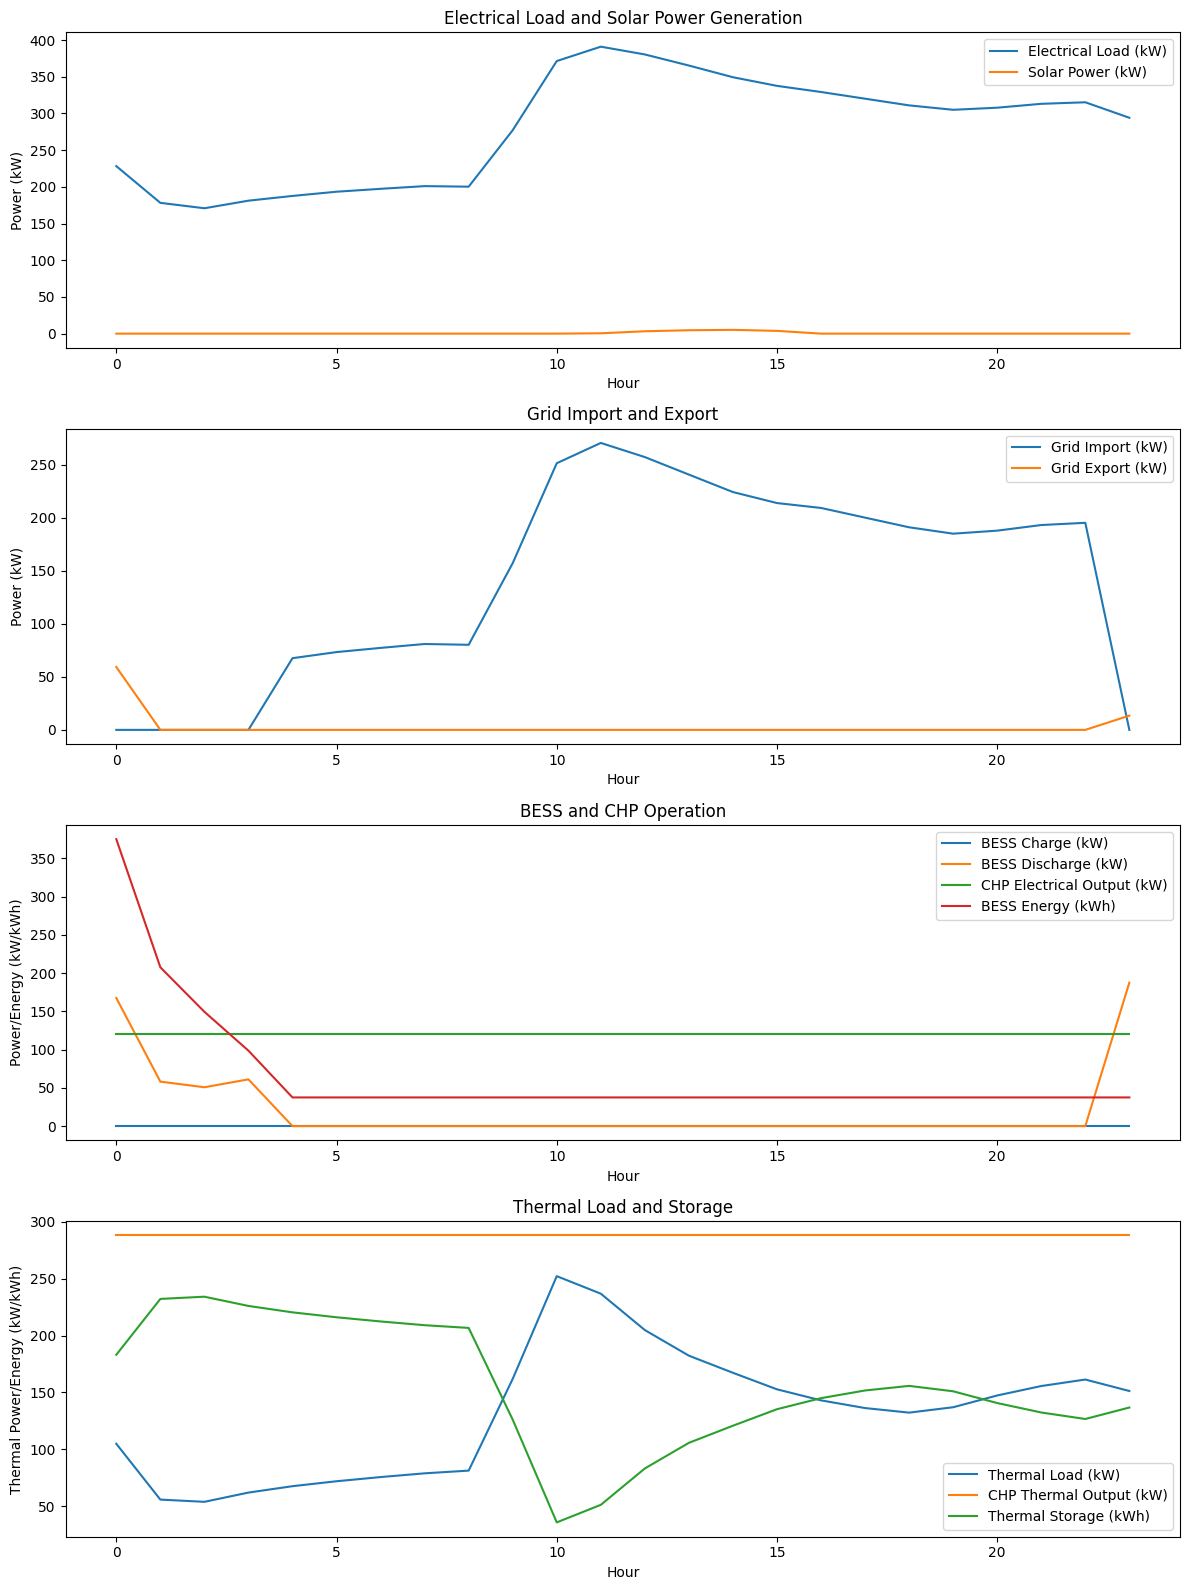

Total Cost: $1949.19185


In [3]:
import pulp as pl
import pandas as pd
import matplotlib.pyplot as plt

# Define the time horizon
hours = range(24)

# Load profiles (electrical and thermal)
electrical_load = [228.15, 178.15, 170.79, 181.12, 187.57, 193.32, 197.26, 200.94, 200.19, 277.15, 371.33, 390.9,
                   380.31, 365.21, 349.28, 337.52, 329.16, 320.04, 310.94, 304.92, 307.78, 313.06, 315.16, 294.06]

thermal_load = [104.87, 55.81, 53.85, 61.98, 67.6, 71.94, 75.61, 78.9, 81.29, 161.93, 252.21, 236.8, 204.82, 182.3,
                167.25, 152.73, 143.03, 136.27, 132.25, 136.99, 147.33, 155.63, 161.34, 151.26]

# Solar power generation
solar_power = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.452, 3.204,
               4.609, 5.137, 3.741, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

# BESS parameters
BESS_max_capacity = 375
BESS_max_hourly_discharge_charge = 187.5
BESS_min_charge = 37.5

# CHP parameters
CHP_electrical_output = 120
CHP_thermal_output = CHP_electrical_output * 2.4  # 288 kWh
CHP_fuel_cost_per_hour = 6

# Grid rates
grid_rate = 0.55

# Create the MILP problem
prob = pl.LpProblem("Microgrid_Economic_Dispatch", pl.LpMinimize)

# Decision variables
grid_import = pl.LpVariable.dicts("Grid_Import", hours, 0)
grid_export = pl.LpVariable.dicts("Grid_Export", hours, 0)
BESS_charge = pl.LpVariable.dicts("BESS_Charge", hours, 0)
BESS_discharge = pl.LpVariable.dicts("BESS_Discharge", hours, 0)
BESS_energy = pl.LpVariable.dicts("BESS_Energy", hours, 0, BESS_max_capacity)
thermal_storage = pl.LpVariable.dicts("Thermal_Storage", hours, 0, None)

# Objective function: Minimize the total cost
prob += pl.lpSum([
    grid_import[h] * grid_rate - grid_export[h] * grid_rate + CHP_fuel_cost_per_hour
    for h in hours
])

# Constraints
for h in hours:
    # Power balance
    prob += (grid_import[h] + BESS_discharge[h] + CHP_electrical_output + solar_power[h] - grid_export[h] - BESS_charge[h] - electrical_load[h] == 0)

    # Thermal balance
    prob += (CHP_thermal_output - thermal_load[h] == thermal_storage[h])

    # Thermal storage balance
    if h == 0:
        prob += (thermal_storage[h] == max(0, CHP_thermal_output - thermal_load[h]))
    else:
        prob += (thermal_storage[h] == max(0, CHP_thermal_output - thermal_load[h]))

    # BESS constraints
    if h == 0:
        prob += (BESS_energy[h] == BESS_max_capacity)
    else:
        prob += (BESS_energy[h] == BESS_energy[h-1] + BESS_charge[h-1] - BESS_discharge[h-1])
    prob += (BESS_charge[h] <= BESS_max_hourly_discharge_charge)
    prob += (BESS_discharge[h] <= BESS_max_hourly_discharge_charge)
    prob += (BESS_energy[h] >= BESS_min_charge)
    prob += (BESS_energy[h] <= BESS_max_capacity)

# Solve the problem
prob.solve()

# Extracting the results into a DataFrame for better visualization
results = {
    "Hour": list(hours),
    "Grid Import (kW)": [grid_import[h].varValue for h in hours],
    "Grid Export (kW)": [grid_export[h].varValue for h in hours],
    "BESS Charge (kW)": [BESS_charge[h].varValue for h in hours],
    "BESS Discharge (kW)": [BESS_discharge[h].varValue for h in hours],
    "CHP Electrical Output (kW)": [CHP_electrical_output for h in hours],
    "CHP Thermal Output (kW)": [CHP_thermal_output for h in hours],
    "BESS Energy (kWh)": [BESS_energy[h].varValue for h in hours],
    "Thermal Storage (kWh)": [thermal_storage[h].varValue for h in hours],
    "Electrical Load (kW)": electrical_load,
    "Thermal Load (kW)": thermal_load,
    "Solar Power (kW)": solar_power
}
df = pd.DataFrame(results)

# Print the table
print(df)

# Plotting the results
fig, axs = plt.subplots(4, 1, figsize=(12, 16))

# Subplot 1: Electrical Load and Solar Power
axs[0].plot(df['Hour'], df['Electrical Load (kW)'], label='Electrical Load (kW)')
axs[0].plot(df['Hour'], df['Solar Power (kW)'], label='Solar Power (kW)')
axs[0].set_xlabel('Hour')
axs[0].set_ylabel('Power (kW)')
axs[0].legend()
axs[0].set_title('Electrical Load and Solar Power Generation')

# Subplot 2: Grid Import/Export
axs[1].plot(df['Hour'], df['Grid Import (kW)'], label='Grid Import (kW)')
axs[1].plot(df['Hour'], df['Grid Export (kW)'], label='Grid Export (kW)')
axs[1].set_xlabel('Hour')
axs[1].set_ylabel('Power (kW)')
axs[1].legend()
axs[1].set_title('Grid Import and Export')

# Subplot 3: BESS and CHP Operation
axs[2].plot(df['Hour'], df['BESS Charge (kW)'], label='BESS Charge (kW)')
axs[2].plot(df['Hour'], df['BESS Discharge (kW)'], label='BESS Discharge (kW)')
axs[2].plot(df['Hour'], df['CHP Electrical Output (kW)'], label='CHP Electrical Output (kW)')
axs[2].plot(df['Hour'], df['BESS Energy (kWh)'], label='BESS Energy (kWh)')
axs[2].set_xlabel('Hour')
axs[2].set_ylabel('Power/Energy (kW/kWh)')
axs[2].legend()
axs[2].set_title('BESS and CHP Operation')

# Subplot 4: Thermal Load and Storage
axs[3].plot(df['Hour'], df['Thermal Load (kW)'], label='Thermal Load (kW)')
axs[3].plot(df['Hour'], df['CHP Thermal Output (kW)'], label='CHP Thermal Output (kW)')
axs[3].plot(df['Hour'], df['Thermal Storage (kWh)'], label='Thermal Storage (kWh)')
axs[3].set_xlabel('Hour')
axs[3].set_ylabel('Thermal Power/Energy (kW/kWh)')
axs[3].legend()
axs[3].set_title('Thermal Load and Storage')

plt.tight_layout()
plt.show()

# Print the total cost
total_cost = pl.value(prob.objective)
print(f"Total Cost: ${total_cost}")